In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import colors

In [2]:
def sample_triangle(triangle_verts, num_samples):
    v = np.stack((triangle_verts[1], triangle_verts[2]))
    a = np.random.rand(num_samples, 2)
    return a.dot(v)

def sample_triangle2(triangle_verts, r):
    sq1 = np.sqrt(r[0])
    m1 = (1 - sq1) * triangle_verts[0]
    m2 = sq1 * (1 - r[1]) * triangle_verts[1]
    m3 = sq1 * r[1] * triangle_verts[2]
    return m1 + m2 + m3

def shift_impl(x, y):
    x *= 0.5
    return x, y-x

def square2triangle2(s):
    x, y = s
    if y > x:
        x, y = shift_impl(x, y)
    else:
        y, x = shift_impl(y, x)
    return x, y

def square2triangle(s):
    t1, t2 = s * 0.5
    offset = t2 - t1
    if offset > 0:
        t2 += offset
    else:
        t1 -= offset
    return t1, t2

def sample_triangle3(triangle_verts, s):
    t1, t2 = square2triangle2(s)
    m1 = triangle_verts[0] * t1
    m2 = triangle_verts[1] * t2
    m3 = triangle_verts[2] * (1 - t1 - t2)
    return m1 + m2 + m3

def is_inside(v, triangle_verts):
    v0 = triangle_verts[0]
    v1 = triangle_verts[1]
    v2 = triangle_verts[2]
    d_2 = np.linalg.det(np.stack([v, v2]).T)
    d_1 = np.linalg.det(np.stack([v, v1]).T)
    d02 = np.linalg.det(np.stack([v0, v2]).T)
    d01 = np.linalg.det(np.stack([v0, v1]).T)
    d12 = np.linalg.det(np.stack([v1, v2]).T)
    a = (d_2 - d02) / d12
    b = -(d_1 - d01) / d12
    return a > 0 and b > 0 and (a + b) < 1

(10000, 2)


(-0.1, 1.1)

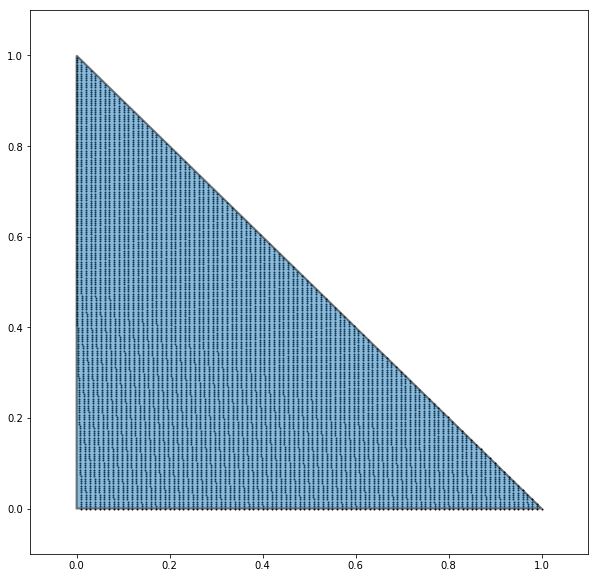

In [3]:
triangle_verts = [
    np.array([0, 0]),
    np.array([0, 1]),
    np.array([1, 0]),
    (0, 0)
]
triangle_codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]

ht_verts = [
    triangle_verts[0],
    triangle_verts[0] + (triangle_verts[1] + triangle_verts[2])
]

path = Path(triangle_verts, triangle_codes)
ht = Path(ht_verts, [Path.MOVETO, Path.LINETO])
#points = sample_triangle(triangle_verts, 1000)
regular = np.vstack([np.linspace(0, 1, 10000), np.tile(np.linspace(0, 1, 100), 100)]).T
#print(regular)
rands = np.random.rand(1000, 2)
points = np.apply_along_axis(lambda r: sample_triangle3(triangle_verts, r), 1, regular)
def test_func(point):
    print(point.shape)
    return np.sum(point)
print(points.shape)
inside = np.apply_along_axis(lambda p: is_inside(p, triangle_verts), 1, points)
points_inside = points[inside]


fig, ax = plt.subplots(figsize=(10, 10))
poly = patches.PathPatch(path, facecolor=None, lw=2, alpha=0.5)
ht = patches.PathPatch(ht)
ax.scatter(points.T[0], points.T[1], s=1, c='black')
ax.add_patch(poly)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
# ax.add_patch(ht)

In [4]:
def choose_left(vmin, vmax):
    vmv = vmax - vmin
    a = vmin
    b = vmin + np.array([0, 1]) * vmv[1]
    return a, b

def choose_top(vmin, vmax):
    vmv = vmin - vmax
    a = vmax
    b = vmax + vmv * np.array([1, 0])
    return a, b

def choose_right(vmin, vmax):
    vmv = vmin - vmax
    a = vmax
    b = vmax + vmv * np.array([0, 1])
    return a, b

def choose_bottom(vmin, vmax):
    vmv = vmax - vmin
    a = vmin
    b = vmin + np.array([1, 0]) * vmv[0]
    return a, b

def choose_points(v1, v2, shift, isl):
    if isl:
        vmv = v2 - v1
    else:
        vmv = v1 - v2
        v1 = v2

    a = v1
    b = v1 + vmv * np.roll(np.array([1, 0]), shift)
    return a, b

def sample_aabb(vmin, vmax, ss):
    s1, s2 = ss
    s3 = (2*(s1 + s2)) % 1
    shift = 1 if s1 > 0.5 else 0
    a, b = choose_points(vmin, vmax, shift, s2 > 0.5)
    return lerp(a, b, s3)

In [5]:
def lerp(a, b, bias):
    return a * (1 - bias) + b * bias

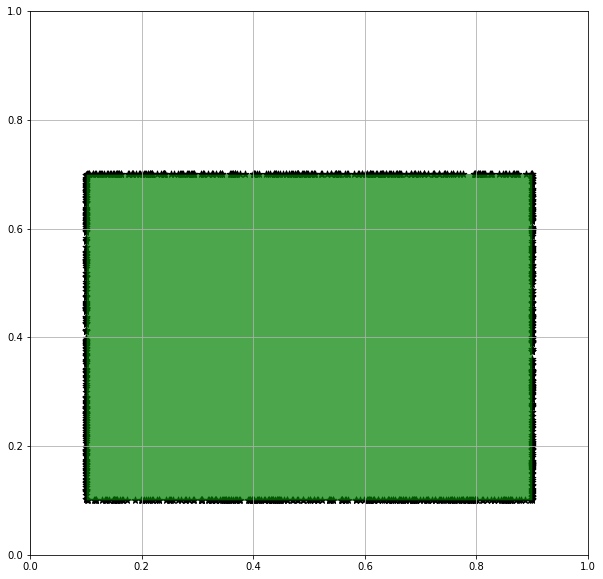

In [6]:
bbox_vmin = np.array([0.1, 0.1])
bbox_vmax = np.array([0.9, 0.7])

box_verts = [
    bbox_vmin,
    bbox_vmin * np.array([1, 0]) + bbox_vmax * np.array([0, 1]),
    bbox_vmax,
    bbox_vmin * np.array([0, 1]) + bbox_vmax * np.array([1, 0]),
    (0, 0)
]

box_codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]

box_path = Path(box_verts, box_codes)

us = np.random.rand(1000, 2)
points = np.array([sample_aabb(bbox_vmin, bbox_vmax, s) for s in us]).T


fig, ax = plt.subplots(figsize=(10, 10))
poly_box = patches.PathPatch(box_path, facecolor='g', lw=0.5, alpha=0.7)
ax.add_patch(poly_box)
ax.scatter(points[0], points[1], s=50, marker='*', c='black')
ax.set_xlim(0, 1)

ax.set_ylim(0, 1)
ax.grid(True)

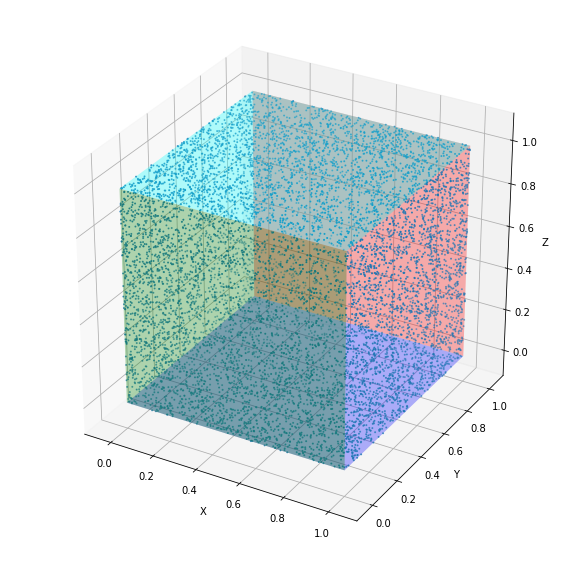

In [7]:
def resample(s):
    return 2 * (s - 0.5 if s > 0.5 else 0.5 - s)

def choose_points(v1, v2, shift, isl):
    if isl:
        vmv = v2 - v1
    else:
        vmv = v1 - v2
        v1 = v2

    a = v1
    b = v1 + vmv * np.roll(np.array([1, 1, 0]), shift)
    return a, b

def sample_aabb(vmin, vmax, ss):
    s1, s2, _ = ss
    s3 = (2*(s1 + s2)) % 1
    shift = int(((s3 + s1 + s2) % 1) * 300)
    a, b = choose_points(vmin, vmax, shift, s3 > 0.5)
    return lerp(a, b, np.roll(np.array([resample(s1), resample(s2), 0]), shift))

def choose_left(vmin, vmax):
    vmv = vmax - vmin
    a = vmin
    b = vmin + vmv * np.array([1, 0, 1])
    return a, b

def choose_right(vmin, vmax):
    vmv = vmin - vmax
    a = vmax
    b = vmax + vmv * np.array([1, 0, 1])
    return a, b

def choose_top(vmin, vmax):
    vmv = vmin - vmax
    a = vmax
    b = vmax + vmv * np.array([1, 1, 0])
    return a, b

def choose_bottom(vmin, vmax):
    vmv = vmax - vmin
    a = vmin
    b = vmin + vmv * np.array([1, 1, 0])
    return a, b

def choose_top(vmin, vmax):
    vmv = vmin - vmax
    a = vmax
    b = vmax + vmv * np.array([1, 1, 0])
    return a, b

def choose_front(vmin, vmax):
    vmv = vmin - vmax
    a = vmax
    b = vmax + vmv * np.array([0, 1, 1])
    return a, b

def choose_back(vmin, vmax):
    vmv = vmax - vmin
    a = vmin
    b = vmin + vmv * np.array([0, 1, 1])
    return a, b

vmin = np.array([0, 0, 0])
vmax = np.array([1, 1, 1])

left = Poly3DCollection([[
    [0, 0, 0],
    [1, 0, 0],
    [1, 0, 1],
    [0, 0, 1]
]], facecolors=[colors.to_rgba('g', alpha=0.3)])
bottom = Poly3DCollection([[
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0]
]], facecolors=[colors.to_rgba('b', alpha=0.3)])
top = Poly3DCollection([[
    [0, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 1, 1]
]], facecolors=[colors.to_rgba('cyan', alpha=0.3)])
right = Poly3DCollection([[
    [0, 1, 0],
    [1, 1, 0],
    [1, 1, 1],
    [0, 1, 1]
]], facecolors=[colors.to_rgba('r', alpha=0.3)])


ss = np.random.rand(3, 10000)
pp = np.apply_along_axis(lambda s: sample_aabb(vmin, vmax, s), 0, ss)
# line_points = choose_left(vmin, vmax)
# line_points = choose_points(vmin, vmax, 2, 1)
# pp = np.apply_along_axis(lambda s: lerp(line_points[0], line_points[1], s), 0, ss)
# print(pp.shape)
def add_lines(ax, func):
    lines = np.vstack(func(vmin, vmax)).T
    ax.plot(lines[0], lines[1], lines[2])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(left)
ax.add_collection3d(bottom)
ax.add_collection3d(top)
ax.add_collection3d(right)
# for func in (choose_left, choose_right, choose_bottom, choose_top, choose_front, choose_back):
#     add_lines(ax, func)
# add_lines(ax, choose_left)
# add_lines(ax, choose_right)
# add_lines(ax, choose_top)
# add_lines(ax, choose_bottom)
# add_lines(ax, choose_front)
# add_lines(ax, choose_back)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim3d(-0.1, 1.1)
ax.set_ylim3d(-0.1, 1.1)
ax.set_zlim3d(-0.1, 1.1)
ax.scatter(pp[0], pp[1], pp[2], s=1)